In [1]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

import pandas as pd
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


import pandas as pd

In [2]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

### Simulate Simple Case Data
- Original Function

In [3]:
def GenerateData(select, CL1=7, CL2=14, CL3=21, seed=None):
    """Class methods are similar to regular functions.

       

        Args:
            param1: The first parameter.
            param2: The second parameter.

        Returns:
            True if successful, False otherwise.

    """
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Using Vectorized 

In [4]:
def GenerateData_vectorized(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

- Using JIT

In [5]:
import numba
from numba import jit

In [6]:
@jit
def GenerateData_jit(select, CL1=7, CL2=14, CL3=21, seed=None):
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Vectorized JIT

In [7]:
@jit
def GenerateData_vectorized_jit(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

- Using Cython

In [8]:
%load_ext cython

In [9]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_cython(select, CL1=7, CL2=14, CL3=21, seed=None):
    if seed:
        random.seed(100)
    if select == 1:
        data = np.zeros((CL2,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        data = np.zeros((CL3,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2,CL3):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

- Vectorized Cython

In [10]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_vectorized_cython(s, c1=7, c2=14, c3=21, seed=None):
    if seed: 
        np.random.seed(seed)
    if s==1:
        x = 1 + np.random.random((c2, 2))
        x[c1:,:] += 2
    elif s==2:
        x = 1 + np.random.random((c3,2))
        x[c1:c2, 0] += 2
        x[c2:, 0] += 0.5
        x[c2:,1] += 2
    return x

#### Using Multi-threading

In [77]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import time
start = time.clock()
res1 = GenerateData(2)
time1 = time.clock()-start

In [78]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(GenerateData, 2)
time2 = time.clock() - start

#### Speed-up ratio (Generate Data)

In [11]:
select = 2
report([GenerateData,GenerateData_vectorized],select)

GenerateData: 1.0
GenerateData_vectorized: 0.2


In [12]:
select = 2
report([GenerateData,GenerateData_jit],select)

GenerateData: 1.0
GenerateData_jit: 0.0


In [13]:
select = 2
report([GenerateData,GenerateData_vectorized_jit],select)

GenerateData: 1.0
GenerateData_vectorized_jit: 0.0


In [14]:
select = 2
report([GenerateData,GenerateData_cython],select)

GenerateData: 1.0
GenerateData_cython: 1.0


In [15]:
select = 2
report([GenerateData,GenerateData_vectorized_cython],select)

GenerateData: 1.0
GenerateData_vectorized_cython: 0.1


#### Multi-Threading

In [79]:
time1/time2

0.008419796466513618

### Simulate Convex Region data 
- Original Function

In [110]:
def CreateCircle(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

In [111]:
def CreateCircle_vectorized(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        c1 = 2*i*100
        c2 = (2*i+1)*100
        c3 = (2*i+2)*100
        df[c1:c2,0] = x
        df[c1:c2,1] = y
        df[c2:c3,0] = x
        df[c2:c3,1] = y2

    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

In [38]:
@jit
def CreateCircle_jit(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

In [39]:
%%cython -a

import cython
import numpy as np
import random


@cython.boundscheck(False)
@cython.wraparound(False)

def CreateCircle_cython(n):
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df


#### Multi-threading

In [131]:
start = time.clock()
cir1 = CreateCircle(2)
time1 = time.clock()-start

In [132]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CreateCircle, 2)
time2 = time.clock() - start



#### Speed-up Ratio( Create Circular Data )

In [40]:
data = CreateCircle(3)
affinity = CalculateAffinity(data)
n = 3

In [121]:
report([CreateCircle,CreateCircle_vectorized],n)

CreateCircle: 1.0
CreateCircle_vectorized: 1.2


In [123]:
report([CreateCircle,CreateCircle_jit],n)

CreateCircle: 1.0
CreateCircle_jit: 2.8


In [125]:
report([CreateCircle,CreateCircle_cython],n)

CreateCircle: 1.0
CreateCircle_cython: 1.5


In [133]:
##Multi-threading
time1/time2

0.03275768371484636

### Calculate Affinity
- Original Function

In [16]:
def CalculateAffinity(data,num_neighbours=5):
    sigma = 0.5
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    A = ( np.ones(affinity.shape) - np.eye(affinity.shape[0])) * affinity
    
    return A

- Using Vectorized

In [50]:
from sklearn.metrics.pairwise import euclidean_distances
def CalculateAffinity_vectorized(data):
    distance = euclidean_distances(data, data)
    sig = 0.5
    similarity = np.exp(-distance/(2*sig**2))
    
    return similarity
    

- Using JIT

In [18]:
@jit
def CalculateAffinity_jit(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


- Vectorized JIT

In [51]:
@jit
def CalculateAffinity_vectorized_jit(data):
    distance = euclidean_distances(data, data)
    sig = 0.5
    similarity = np.exp(-distance/(2*sig**2))
    
    return similarity

- Using Cython

In [20]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_cython(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

- Vectorized Cython

In [53]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_vectorized_cython(data):
    from sklearn.metrics.pairwise import euclidean_distances
    distance = euclidean_distances(data, data)
    sig = 0.5
    similarity = np.exp(-distance/(2*sig**2))
    
    return similarity

#### Using Multi-threading

In [90]:
start = time.clock()
aff1 = CalculateAffinity(data)
time1 = time.clock()-start

In [91]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CalculateAffinity, data)
time2 = time.clock() - start

#### Speed-up Ratio (Calculate Affinity )

In [22]:
data = GenerateData(2)

In [55]:
report([CalculateAffinity,CalculateAffinity_vectorized],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized: 165.3


In [69]:
report([CalculateAffinity,CalculateAffinity_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_jit: 226.6


In [70]:
report([CalculateAffinity,CalculateAffinity_vectorized_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_jit: 163.6


In [64]:
report([CalculateAffinity,CalculateAffinity_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_cython: 1.4


In [66]:
report([CalculateAffinity,CalculateAffinity_vectorized_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_cython: 155.8


In [94]:
##Multi-threading
time1/time2

13.903953527718667

### Spectral Clustering
- Original Function 

In [28]:
def Spectral(k, affinity):
  
    # compute the degree matrix
    #D =  np.zeros((affinity.shape))
    #for i in range(affinity.shape[0]):
        #D[i,i] = sum(affinity[i,:])
    D = np.diag(np.sum(affinity, axis=0))


    #compute the normalized laplacian / affinity matrix
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using JIT

In [29]:
@jit
def Spectral_jit(k,affinity):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 

  
    # apply K-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Cython

In [30]:
%%cython -a

import cython
import numpy as np
import random
import math
import scipy.linalg as la
from sklearn.cluster import KMeans

@cython.boundscheck(False)
@cython.wraparound(False)


def Spectral_cython(k,affinity):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 
    # apply K-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(U)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

In [101]:
start = time.clock()
spec = Spectral(3,aff1)
time1 = time.clock()-start

In [102]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(Spectral, 3, aff1)
time2 = time.clock() - start

#### Speed-up Ratio (Spectral Clustering)

In [31]:
k = 3
data = GenerateData(2)
affinity = CalculateAffinity(data)

In [106]:
report([Spectral,Spectral_cython],k,affinity)

Spectral: 1.0
Spectral_cython: 1.3


In [107]:
report([Spectral,Spectral_jit],k,affinity)

Spectral: 1.0
Spectral_jit: 2.2


In [108]:
##Multithreading
time1/time2

10.04083533887126

### Implementation (Ideal Case)

In [34]:
data = GenerateData(2)
affinity = CalculateAffinity(data)

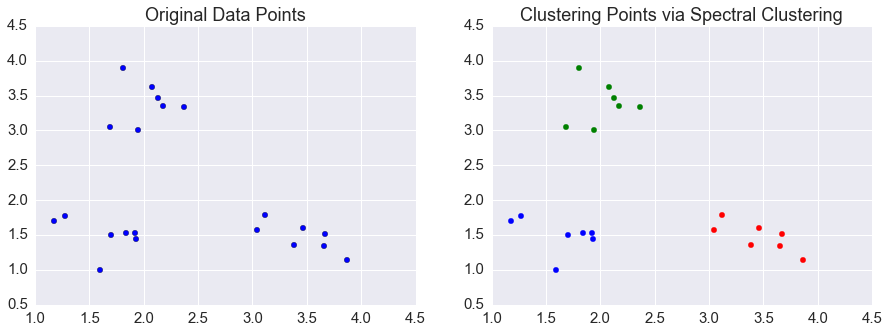

In [35]:
IDX= Spectral(3,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()




### Compare with K-Means (Idea Case)

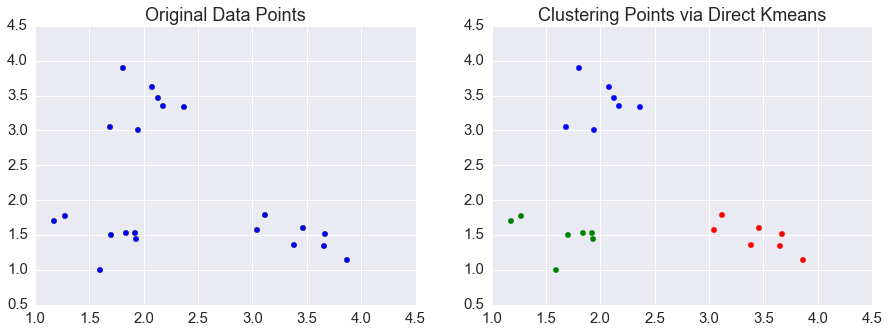

In [36]:
k=3
X=data

# Apply K-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()




### Implementation (Special Case)

In [43]:
k=3
data = CreateCircle(3)
affinity = CalculateAffinity(data)

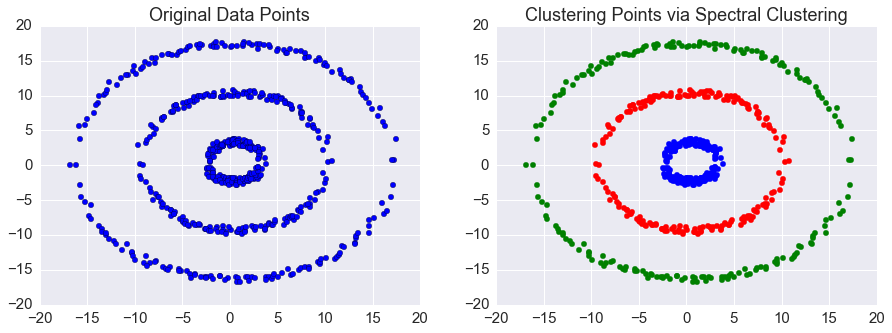

In [44]:
IDX= Spectral(k,affinity)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()



### Compare with K-means (Special Case)

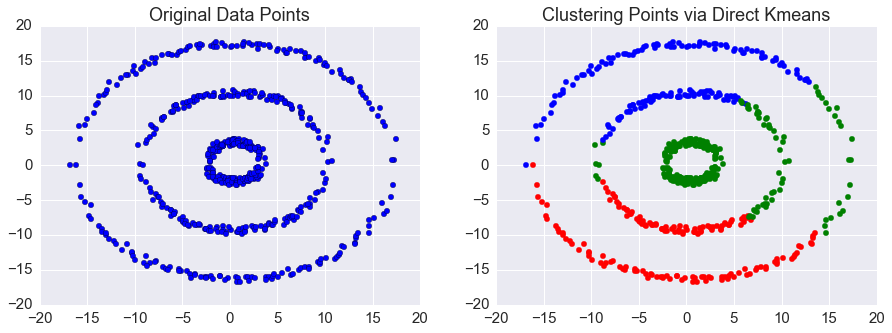

In [45]:
X=CreateCircle(3)

# Apply K-means directly
clust_result = KMeans(n_clusters=3, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()



### Implementation on Real Dataset 

In [46]:
a = np.loadtxt('jain.txt')

In [47]:
data = a[:,0:2]
affinity = CalculateAffinity(data)
k = 2

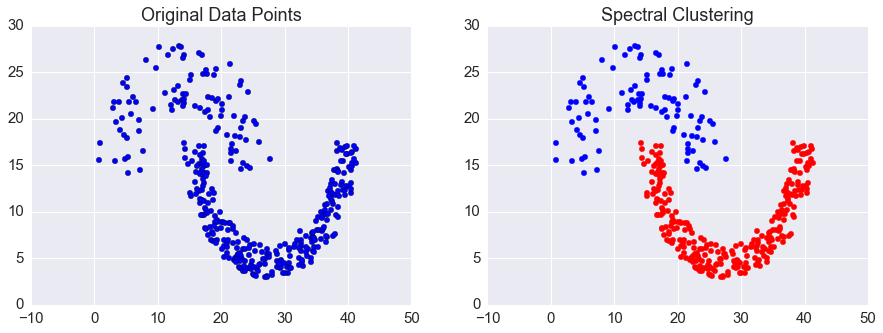

In [48]:
IDX=Spectral(k,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Spectral Clustering')
plt.show()

### Compare with K-means

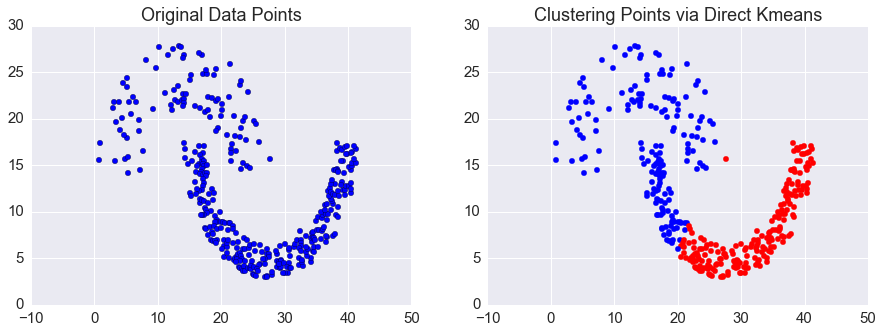

In [49]:
# Apply k-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()